In [3]:
import dill
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import torch

# download all dill files from x.cloud directory:
dill_path = "../ptm_model_bench/base_model_dataset/"

# albert-base-v2
# albert-large-v2
# "distilroberta-base",
# "distilbert-base",
# "xlm-roberta-large",
# "xlm-roberta-base",
# "electra-base-discriminator",
# "electra-large-discriminator",
# "roberta-large",
# "roberta-base",
# "bert-large-uncased",
# "bert-base-uncased"

FONT_COLOR = 'black'
COLOR_MAP = 'cool'

def get_posvals(model_feature, num_layers, num_heads):
    pos_QK = []
    for ldx in range(num_layers):
        pos_val = plot_eigs_by_head_in_layer(model_feature, mat_type="QKt", layer=ldx, head=num_heads)
        pos_QK.append(pos_val)

    pos_VO = []
    for ldx in range(num_layers):
        pos_val = plot_eigs_by_head_in_layer(model_feature, mat_type="VO", layer=ldx, head=num_heads)
        pos_VO.append(pos_val)
        
    return pos_QK, pos_VO

def get_feature(graph_feature, mat_type, layer, head):
    for node_nm in graph_feature.keys():
        if "_" + str(layer) + "_" + mat_type + "_" + str(head) in node_nm:
            feature = graph_feature[node_nm]
            feature = feature.reshape((64,2)).numpy()
    return feature
    
def pos_neg(eig_val):
    row_sum = np.sum(eig_val, axis=0)
    abs_row_sum = np.sum(np.abs(eig_val), axis=0)
    abs_comp_sum = np.sum(np.sqrt(np.sum(eig_val**2, axis=1)), axis=0)
    real_ratio = row_sum[0].item() / abs_row_sum[0].item()
    comp_ratio = row_sum[0].item() / abs_comp_sum.item()
    return real_ratio, comp_ratio

def plot_eigs_by_head_in_layer(graph_feature, mat_type, layer, head):
    res = []
    for hdx in range(head):
        eig = get_feature(graph_feature, mat_type, layer, hdx)
        rr, cr = pos_neg(eig)
        res.append(cr)
    return res

def get_fig(num_layers, pos_QK, pos_VO):
    cmap = plt.cm.get_cmap(COLOR_MAP)
    if num_layers == 1:
        color_list = [cmap(0)]
    else:
        color_div = [x / (num_layers-1) for x in list(range(num_layers))]
        color_list = [cmap(color_div[x]) for x in range(num_layers)]

    for ldx in range(num_layers):
        X = pos_QK[ldx]
        Y = pos_VO[ldx]
        plt.scatter(Y,X, label='layer ' + str(ldx), marker='.', color=color_list[ldx])

    plt.title(model_graph_info[0][2] + " (" + str(num_layers) + ")", color=FONT_COLOR)
    plt.axvline(x=0, color=FONT_COLOR, ls='--', linewidth=0.5)
    plt.axhline(y=0, color=FONT_COLOR, ls='--', linewidth=0.5)
    plt.xlim([-1, 1])
    plt.ylim([-1, 1])
    plt.xticks([-1,0,1], color=FONT_COLOR)
    plt.yticks([-1,0,1], color=FONT_COLOR)

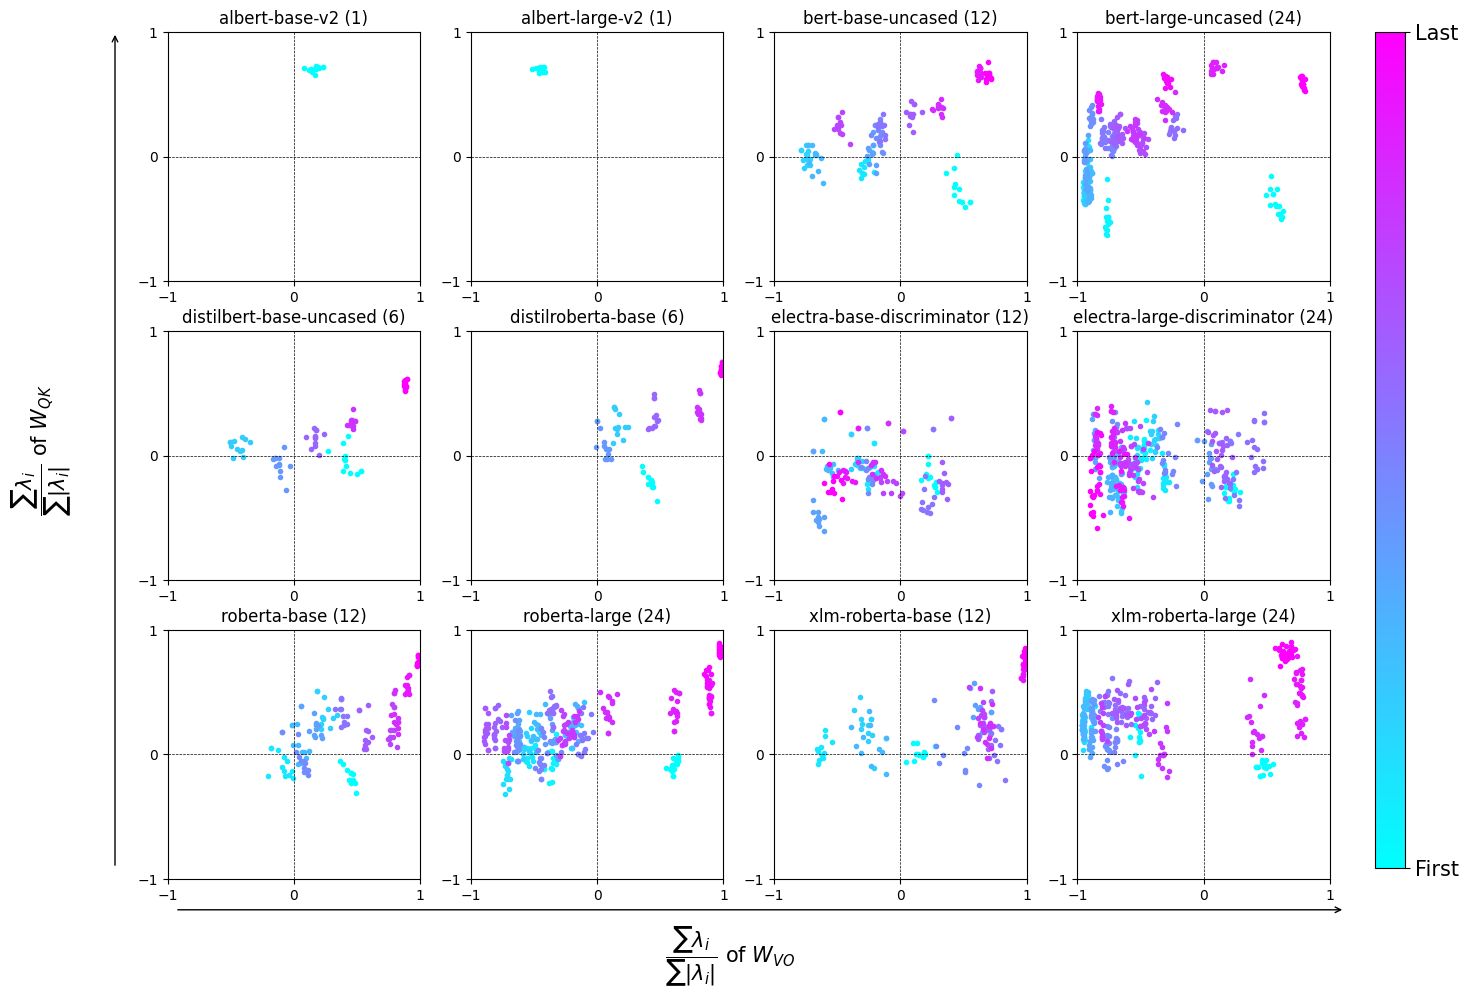

In [5]:
# Choose two base models
model_list = [
    "albert-base-v2",
    "albert-large-v2",
    "bert-base-uncased",
    "bert-large-uncased",
    "distilbert-base-uncased",
    "distilroberta-base",
    "electra-base-discriminator",
    "electra-large-discriminator",
    "roberta-base",
    "roberta-large",
    "xlm-roberta-base",
    "xlm-roberta-large"
]

fig = plt.figure(figsize=(15,11))
for hdx, model in enumerate(model_list):
    
    with open(dill_path + "base_" + model + ".dill", 'rb') as f:
            model_graph_info = dill.load(f)

    model_feature = model_graph_info[0][1]

    if "albert" in model:
        num_layers = 1
        num_heads = 12
    elif "large" in model:
        num_layers = 24
        num_heads = 16
    elif "distil" in model:
        num_layers = 6
        num_heads = 12
    else:
        num_layers = 12
        num_heads = 12

    plt.subplot(3,4,hdx+1)
    QKs, VOs = get_posvals(model_feature, num_layers, num_heads)
    get_fig(num_layers, QKs, VOs)

# fig.supylabel('Eigenvalue positivity of QK')
fig.supylabel(r"$\dfrac{\sum \lambda_i}{\sum| \lambda_i|}$ of $W_{QK}$", fontsize=15, color=FONT_COLOR)
fig.supxlabel(r"$\dfrac{\sum \lambda_i}{\sum| \lambda_i|}$ of $W_{VO}$", fontsize=15, color=FONT_COLOR)

import matplotlib.cm as cm
from matplotlib.colors import Normalize

cmap=cm.get_cmap(COLOR_MAP)
im=cm.ScalarMappable(cmap=cmap)
cbar_ax = fig.add_axes([0.93, 0.12, 0.02, 0.76])
cbar = fig.colorbar(im, cax=cbar_ax, ticks=[-1, 0, 1])
cbar.ax.set_yticklabels(['< -1', 'First', 'Last'], fontsize=15, color=FONT_COLOR)

plt.annotate('', xy=(-1, -0.05), xycoords='axes fraction', xytext=(-40, -0.05), 
            arrowprops=dict(arrowstyle="->", color=FONT_COLOR))
plt.annotate('', xy=(-42, 0), xycoords='axes fraction', xytext=(-42, 1), 
            arrowprops=dict(arrowstyle="<-", color=FONT_COLOR))

plt.savefig('Eigenvalue_positivities_black.eps')
# plt.show()